# NHL Draft Performance Analysis

This notebook is a rework of an analysis originally run solely in pandas and visualized in matplotlib. To reiterate the initial objective, we are trying to discover whether a relationship exists between the positions draftees play and the drafting teams' performances during the subsequent season. In other words, do the incoming players have much affect on performance? My initial intuition says "yes", but we'll explore what the data have to say.

Here we'll be using a jupyter pyspark notebook to better show the workflow as well as take Spark for a spin. Specifically, we'll be relying on Spark SQL to allow us to do the data munging needed to accomplish a chi-squared test. Without further ado, the first thing we need to do is import pyspark and create a spark context to work with.

In [1]:
import pyspark
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .getOrCreate()

Our next step is to get the data loaded into Spark DataFrames. We are working with two different datasets:
<ul><strong>1)</strong> A performance dataset that gives teams' win/loss records</ul>
<ul><strong>2)</strong> A draftee dataset that gives draftees and their prefered positions</ul>

We'll choose to have Spark infer the schema for simplicity's sake because the data types are straight forward, and we'll use the "failFast" mode to allow Spark to notify us if anything went wrong with the read.

In [2]:
performance_df = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .option("mode", "failFast")\
    .load("performance_data.csv")

draft_df = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .option("mode", "failFast")\
    .load("draft_data.csv")

In [3]:
draft_df = draft_df.drop(draft_df.pick_points)

In [4]:
type(performance_df)

pyspark.sql.dataframe.DataFrame

In [5]:
performance_df.show(5)

+---+----+----+---+---+---+---------+--------------------+
|_c0|Year|Team| GP|  W|  L|year_diff|         wins_change|
+---+----+----+---+---+---+---------+--------------------+
|232|2007| ANA| 82| 48| 20|     null|                null|
|267|2008| ANA| 82| 47| 27|      1.0|-0.02083333333333337|
|313|2009| ANA| 82| 42| 33|      1.0| -0.1063829787234043|
|345|2010| ANA| 82| 39| 32|      1.0| -0.0714285714285714|
|372|2011| ANA| 82| 47| 30|      1.0| 0.20512820512820507|
+---+----+----+---+---+---+---------+--------------------+
only showing top 5 rows



In [6]:
draft_df.show(5)

+---+-----+----+-------+----+------------------+--------+----+------------+
|_c0|Round|Pick|Overall|Team|            Player|Position|Year|overall_pick|
+---+-----+----+-------+----+------------------+--------+----+------------+
|  0|  1.0| 1.0| 2018-1| BUF|     Rasmus Dahlin|       D|2018|           1|
|  1|  1.0| 2.0| 2018-2| CAR| Andrei Svechnikov|       F|2018|           2|
|  2|  1.0| 3.0| 2018-3| MTL|Jesperi Kotkaniemi|       F|2018|           3|
|  3|  1.0| 4.0| 2018-4| OTT|     Brady Tkachuk|       F|2018|           4|
|  4|  1.0| 5.0| 2018-5| ARI|    Barrett Hayton|       F|2018|           5|
+---+-----+----+-------+----+------------------+--------+----+------------+
only showing top 5 rows



## Feature Engineering

Now we can see what we're working with. Our end goal is a Chi-Squared test to understand if a relationship between performance and draftee position exists. Chi-Squared tests rely on contingency tables to analyze two categorical variables for relationship. So, we'll need a categorical variable that represents team performance year over year. We'll also need a categorical variable that represents draftees prefered positions aggregated at the team level. In order to do this, we'll need to do some feature engineering. 

We'll start with team performance. Using the "wins_change" column, which represents percent change in wins year over year, we'll create a column containing a categorical variable describing whether the team went positive or negative.

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Create User Defined Function (UDF) to allow us to create categorical column based on wins_change column
udf = udf(lambda x: "positive" if x >= 0 else "negative", StringType())

# We drop NaNs from our wins_change column because we cannot use data that doesn't have a percent change YoY
performance_df = performance_df.na.drop()

# We add the new column using our UDF and the select method; We'll also filter for year_diff == 1
name = "wins_change"
performance_df = performance_df.select(*[udf(column).alias('wins_change_cat') \
                                         if column == name else column \
                                         for column in performance_df.columns]).where(performance_df.year_diff == 1)




In [8]:
performance_df.show(5)

+---+----+----+---+---+---+---------+---------------+
|_c0|Year|Team| GP|  W|  L|year_diff|wins_change_cat|
+---+----+----+---+---+---+---------+---------------+
|267|2008| ANA| 82| 47| 27|      1.0|       negative|
|313|2009| ANA| 82| 42| 33|      1.0|       negative|
|345|2010| ANA| 82| 39| 32|      1.0|       negative|
|372|2011| ANA| 82| 47| 30|      1.0|       positive|
|419|2012| ANA| 82| 34| 36|      1.0|       negative|
+---+----+----+---+---+---+---------+---------------+
only showing top 5 rows



As with several aspects of Pyspark, we can do the above operation another way. We can use the Spark SQL when() function to allow us to create a new column using syntax similar to SQL CASE operations. This allows us to accomplish the same task with a single line of code that is more intuitive and readable. Additionally, we get to circumvent the use of UDFs in Pyspark, which happen to be very costly for each executor.

In [9]:
from pyspark.sql.functions import when

# Re-load DataFrame to keep namespace clean
when_example = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .option("mode", "failFast")\
    .load("performance_data.csv")

# Call when().otherwise() within select(), then alias
when_example.select("*",\
            when(when_example.wins_change >= 0, "positive")\
            .otherwise("negative")\
            .alias("wins_change_cat"))\
            .show(5)


+---+----+----+---+---+---+---------+--------------------+---------------+
|_c0|Year|Team| GP|  W|  L|year_diff|         wins_change|wins_change_cat|
+---+----+----+---+---+---+---------+--------------------+---------------+
|232|2007| ANA| 82| 48| 20|     null|                null|       negative|
|267|2008| ANA| 82| 47| 27|      1.0|-0.02083333333333337|       negative|
|313|2009| ANA| 82| 42| 33|      1.0| -0.1063829787234043|       negative|
|345|2010| ANA| 82| 39| 32|      1.0| -0.0714285714285714|       negative|
|372|2011| ANA| 82| 47| 30|      1.0| 0.20512820512820507|       positive|
+---+----+----+---+---+---+---------+--------------------+---------------+
only showing top 5 rows



Great, now we have a categorical representation of performance by team, by year. Next up is to create a feature that represents the team's drafting preferences in regards to player position. We can use a point system to award a heavier weighting to players who were picked earlier in the draft (because we know the draft order for every year). We can then sum the points together and evaluate the preferred position for a team. Let's give it a go with a DataFrame.

In [10]:
from pyspark.sql.functions import sum, max, expr
from pyspark.sql.types import IntegerType

# First we create a feature that represents a multiplier for the round (higher multipliers for earlier rounds)
# There are 7 rounds in every draft, so we subtract from 8 (to avoid a 0 multiplier)
draft_df = draft_df.withColumn("round_mult", 8 - draft_df.Round)

# We multiply the order of the pick by the multiplier for the round (there are 39 picks per round)
draft_df = draft_df.withColumn("pick_points", (draft_df.round_mult * (39 - draft_df.Pick)))

# Cast our new columns as integers by creating a new column, casting that new col, then renaming
draft_df = draft_df.withColumn("rm", draft_df.round_mult.cast(IntegerType())).drop("round_mult")\
                   .withColumnRenamed("rm", "round_mult")\
                   .withColumn("pp", draft_df.pick_points.cast(IntegerType())).drop("pick_points")\
                   .withColumnRenamed("pp", "pick_points")

draft_df.show(5)

+---+-----+----+-------+----+------------------+--------+----+------------+----------+-----------+
|_c0|Round|Pick|Overall|Team|            Player|Position|Year|overall_pick|round_mult|pick_points|
+---+-----+----+-------+----+------------------+--------+----+------------+----------+-----------+
|  0|  1.0| 1.0| 2018-1| BUF|     Rasmus Dahlin|       D|2018|           1|         7|        266|
|  1|  1.0| 2.0| 2018-2| CAR| Andrei Svechnikov|       F|2018|           2|         7|        259|
|  2|  1.0| 3.0| 2018-3| MTL|Jesperi Kotkaniemi|       F|2018|           3|         7|        252|
|  3|  1.0| 4.0| 2018-4| OTT|     Brady Tkachuk|       F|2018|           4|         7|        245|
|  4|  1.0| 5.0| 2018-5| ARI|    Barrett Hayton|       F|2018|           5|         7|        238|
+---+-----+----+-------+----+------------------+--------+----+------------+----------+-----------+
only showing top 5 rows



Now we need to designate a preferred position for each team, for each year.

In [11]:
# First we sum the points by Year, team, and position
draft_grouped_df = draft_df.select(["Year", "Team", "Position", "pick_points"]) \
                           .groupBy(["Year", "Team", "Position"])\
                           .agg(expr("sum(pick_points) AS pick_sum"))

# Next we take the preferred position based on max points
join_frame = draft_grouped_df.select(["Year", "Team", "Position", "pick_sum"]) \
                                   .groupBy(["Year", "Team"]).agg(expr("max(pick_sum) AS pick_sum"))

# Add the position column back into our max points DataFrame
draft_grouped_df = join_frame.join(draft_grouped_df, on=["Year", "Team", "pick_sum"], how='left')\
                             .withColumnRenamed("Position", "preferred_position")
                                   

draft_grouped_df.show(5)

+----+----+--------+------------------+
|Year|Team|pick_sum|preferred_position|
+----+----+--------+------------------+
|2010| WSH|     323|                 F|
|1979| MNS|    1083|                 F|
|2003| FLA|    1260|                 F|
|1978| TOR|     618|                 D|
|2012| PIT|     462|                 F|
+----+----+--------+------------------+
only showing top 5 rows



In [12]:
draft_grouped_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Team: string (nullable = true)
 |-- pick_sum: long (nullable = true)
 |-- preferred_position: string (nullable = true)



In [13]:
from pyspark.sql.functions import col

# Cleaning values in position column to reflect a generic "F" for forward position
draft_grouped_df = draft_grouped_df.withColumn("new", when(col("preferred_position").like("LW/D"), "F")\
                           .when(col("preferred_position").like("LW/RW"), "F")\
                           .when(col("preferred_position").like("C/RW"), "F")\
                           .when(col("preferred_position").like("C/LW"), "F")\
                           .otherwise(col("preferred_position")))\
                           .drop("preferred_position")\
                           .withColumnRenamed("new", "preferred_position")\
                           .dropna()

draft_grouped_df.show(5)

+----+----+--------+------------------+
|Year|Team|pick_sum|preferred_position|
+----+----+--------+------------------+
|2010| WSH|     323|                 F|
|1979| MNS|    1083|                 F|
|2003| FLA|    1260|                 F|
|1978| TOR|     618|                 D|
|2012| PIT|     462|                 F|
+----+----+--------+------------------+
only showing top 5 rows



## Joining the Tables

Now that we've got a preferred position categorical feature for each team during each season, we'll use team and year to join the two categorical variables. To accomplish this we'll use SQL queries.

In [14]:
from pyspark.sql.functions import count

# First we need to register the DataFrames as Tables
performance_df.createOrReplaceTempView("performanceTable")
draft_grouped_df.createOrReplaceTempView("draftTable")

# Next we write our query and then use the Spark Context to query the tables
query = """
SELECT d.preferred_position, p.wins_change_cat, count(d.Year), count(d.Team) FROM draftTable d
INNER JOIN performanceTable p ON p.Year=d.Year
AND p.Team=d.Team
GROUP BY d.preferred_position, p.wins_change_cat
ORDER BY d.preferred_position, p.wins_change_cat
"""
result = spark.sql(query)
result.show()

+------------------+---------------+-----------+-----------+
|preferred_position|wins_change_cat|count(Year)|count(Team)|
+------------------+---------------+-----------+-----------+
|                 D|       negative|        103|        103|
|                 D|       positive|        134|        134|
|                 F|       negative|        372|        372|
|                 F|       positive|        371|        371|
|                 G|       negative|          8|          8|
|                 G|       positive|          6|          6|
+------------------+---------------+-----------+-----------+



We are now one step away from our contingency matrix. We need to pivot the wins_change_cat and sum the year and team columns.

In [15]:
contingency = result.select(['preferred_position', 'wins_change_cat', 'count(Year)']) \
        .groupBy('preferred_position').pivot('wins_change_cat').sum()

contingency.show()

+------------------+--------+--------+
|preferred_position|negative|positive|
+------------------+--------+--------+
|                 F|     372|     371|
|                 D|     103|     134|
|                 G|       8|       6|
+------------------+--------+--------+



And there we have it! A contingency table that we can use to run our Chi Squared Test. From here we'll rely on the original code from the analysis to run the test and graph the results.

## Chi-Squared Test and Plotting

In [16]:
import numpy as np
from scipy.stats import chi2_contingency, chi2
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

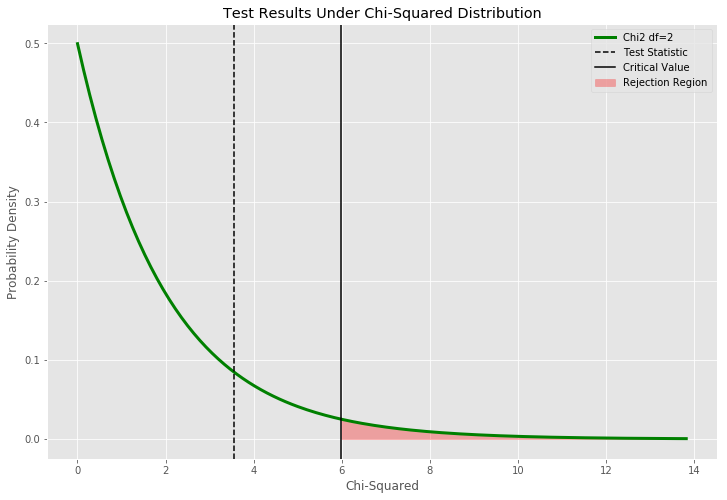

In [17]:
pd_df = contingency.toPandas()
chi_test_data = pd_df.values.T[1:, :]

cs_result, pval_result, df, exp_result = chi2_contingency(chi_test_data)

df = 2
x = np.linspace(chi2.ppf(0.001, df), chi2.ppf(0.999, df), 200)
rv = chi2(df)

val = chi2.ppf(0.95, df)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, rv.pdf(x), lw=3, label='Chi2 df=2', color='green')
ax.axvline(cs_result, color='k', linestyle='--', label='Test Statistic')
ax.axvline(val, color='k', label='Critical Value')
xprime = np.linspace(val, chi2.ppf(.999, df), 200)
ax.fill_between(xprime, 0, chi2.pdf(xprime, df), color='red', alpha=.3, label='Rejection Region')
ax.set_title('Test Results Under Chi-Squared Distribution')
ax.set_xlabel('Chi-Squared')
ax.set_ylabel('Probability Density')
plt.legend(loc='upper right');

## Conclusion and Final Thoughts

The test resulted in a test statistic of 3.61, which under the chi-squared distribution where degrees of freedom were 2, yielded a p-value of 0.16. This value fell well outside the rejection region of 0.05. We therefore cannot conclude on the relationship between position preference and performance given the data.

Although the test statistic fell outside the rejection region, my interpretation is that there still might be a relationship that we weren't able to conclude on. The test statistic fell ahead of the distribution mean, and more intuitively it makes sense that incoming players to a team's roster would have impact on their season performance. My ultimate conclusion is a call for further study and the inclusion of more data. I think this can be broached in two different ways. A more broad inclusion of player data to include all incoming players to a team and their position. This would likely represent a need for player trade data. Another more granular approach to increasing the data would be to include player specific statistics. It makes sense that player history would give some insight into how that player might impact team-level performance.

Finally, we got to showcase some of Spark SQL's ability in this analysis to engineer features and allow us to compare and munge across multiple data sources. Often the code was more succinct than the original analysis and more readable as well. Although this dataset was essentially a toy dataset with respect to size, if we were to follow the above recommendation and acquire additional player trade data and player performance data on the game level, then the data set would grow fast and potentially represent an actual workload for a cluster. At the very least it was a great opportunity to get our feet wet with Spark SQL functionality.